0. Libraries

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn import hmm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib  # For saving and loading the model
import os

1. Download Data

In [ ]:
# Download historical data
ticker = "GC=F"
data = yf.download(ticker, start="2000-01-01", end="2025-03-01")
data = data[['Open', 'High', 'Low', 'Close']]
lookback = 21

# Create features
data['Returns'] = data['Close'].pct_change() * 100  # Percentage returns
data['Volatility'] = data['Returns'].rolling(lookback, min_periods=1).std()  # Historical volatility
data = data.iloc[lookback:]  # Keeps all rows from lookback period onward
data.dropna(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


2. Add Features

In [3]:
"""Scale features using walk-forward method"""
# Initialize scaler with first observation
scaler = StandardScaler()
scaled_features = np.zeros((len(data), 2))

# Walk-forward scaling
for i in range(len(data)):
    if i < 21:  # Warm-up period for volatility
        scaled_features[i] = [0, 0]
        continue
        
    # Use only data up to current point for scaling
    current_data = data.iloc[:i+1]
    scaler.fit(current_data[['Returns', 'Volatility']])
    # Reshape the current observation to 2D array
    current_observation = data.iloc[i][['Returns', 'Volatility']].values.reshape(1, -1)
    scaled_features[i] = scaler.transform(current_observation)

features = pd.DataFrame(scaled_features, columns=['Returns', 'Volatility'], index=data.index)

3. Train-Test Split

In [ ]:
# Split into train/test (2010-2024 train, 2024-2025 test)
train_mask = features.index < '2024-01-01'
# train_mask = features.index > '2017-01-01'
test_mask = features.index >= '2024-01-01'

4. Train Hidden Markov Model

In [8]:
"""Train HMM with multiple initializations"""
best_model = None
best_score = -np.inf
n_states = 4

# Multiple initializations to avoid local maxima
for _ in range(10):
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=1000,
        implementation="log",
        random_state=np.random.randint(0, 1000)
    )
    model.fit(features[train_mask])
    score = model.score(features[train_mask])
    if score > best_score:
        best_score = score
        best_model = model

5. Predict Regimes

In [9]:
# Predict on entire dataset (test predictions are out-of-sample)
hidden_states = model.predict(features)
data['Regime'] = hidden_states

6. Plot Data

C:\Users\najdu\AppData\Local\Temp\ipykernel_8296\1339529631.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', model.n_components)


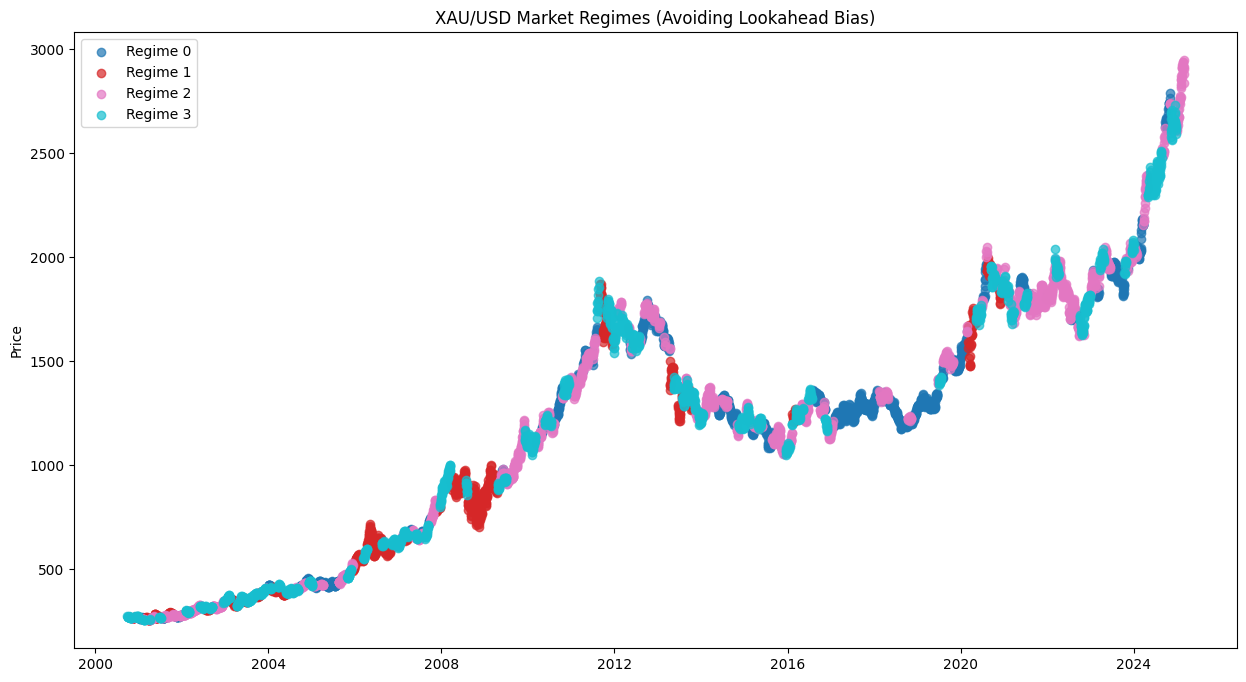

Regime Characteristics (Train Period 2010-2024):

Regime 0:
Average Return: 0.0367%
Average Volatility: 0.6561%
Duration: 27.7%

Regime 1:
Average Return: -0.0340%
Average Volatility: 1.6790%
Duration: 16.9%

Regime 2:
Average Return: 0.0754%
Average Volatility: 0.8718%
Duration: 30.9%

Regime 3:
Average Return: 0.0520%
Average Volatility: 1.1335%
Duration: 24.6%

Test Set Results (2024-2025):

Regime 0 occurred 68 times
Test Period Returns: 0.2123%

Regime 1 occurred 0 times
Test Period Returns: nan%

Regime 2 occurred 108 times
Test Period Returns: 0.1698%

Regime 3 occurred 116 times
Test Period Returns: 0.0035%


In [11]:
# Plot results
plt.figure(figsize=(15, 8))
# Dynamically generate colors based on number of regimes
colors = plt.cm.get_cmap('tab10', model.n_components)

for i in range(model.n_components):
    mask = data['Regime'] == i
    plt.scatter(data.index[mask], data['Close'][mask], 
                c=[colors(i)], label=f'Regime {i}', alpha=0.7)

plt.title('XAU/USD Market Regimes (Avoiding Lookahead Bias)')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print regime statistics (train set only for parameters)
print("Regime Characteristics (Train Period 2010-2024):")
train_data = data[train_mask]
for i in range(model.n_components):
    regime_data = train_data[train_data['Regime'] == i]
    print(f"\nRegime {i}:")
    print(f"Average Return: {regime_data['Returns'].mean():.4f}%")
    print(f"Average Volatility: {regime_data['Volatility'].mean():.4f}%")
    print(f"Duration: {len(regime_data)/len(train_data):.1%}")

# Test set evaluation
print("\nTest Set Results (2024-2025):")
test_data = data[test_mask]
for i in range(model.n_components):
    regime_data = test_data[test_data['Regime'] == i]
    print(f"\nRegime {i} occurred {len(regime_data)} times")
    print(f"Test Period Returns: {regime_data['Returns'].mean():.4f}%")

7. Save Model

In [13]:
def save_model(model, filename="hmm_xauusd_model.pkl"):
    """Save the trained HMM model to a file"""
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

def load_model(filename="hmm_xauusd_model.pkl"):
    """Load a trained HMM model from a file"""
    if not os.path.exists(filename):
        raise FileNotFoundError(f"Model file {filename} not found")
    model = joblib.load(filename)
    print(f"Model loaded from {filename}")
    return model

# Save the trained model
save_model(best_model, "hmm_xauusd_model.pkl")

# Load the model (for demonstration)
loaded_model = load_model("hmm_xauusd_model.pkl")

Model saved to hmm_xauusd_model.pkl
Model loaded from hmm_xauusd_model.pkl


8. Feed New Data

In [ ]:
def download_todays_data():
    """Download today's XAU/USD data"""
    data = yf.download("GC=F", period="1d", interval="1d")
    return data[['Open', 'High', 'Low', 'Close']]

def prepare_todays_features(data, lookback=21):
    """
    Prepare features for today's prediction using historical data.
    Returns a DataFrame with today's features.
    """
    # Download additional historical data for volatility calculation
    historical_data = yf.download("XAUUSD=X", period=f"{lookback+1}d", interval="1d")
    historical_data['Returns'] = historical_data['Close'].pct_change() * 100
    historical_data['Volatility'] = historical_data['Returns'].rolling(lookback).std()
    
    # Get today's returns and volatility
    today_data = historical_data.iloc[-1].to_frame().T
    today_data['Returns'] = (today_data['Close'] - today_data['Open']) / today_data['Open'] * 100
    today_data['Volatility'] = historical_data['Volatility'].iloc[-1]
    
    return today_data[['Returns', 'Volatility']]

def predict_todays_regime(model_filename="hmm_xauusd_model.pkl"):
    """
    Predict today's market regime using the saved HMM model.
    """
    # Load the saved model
    model = joblib.load(model_filename)
    
    # Download and prepare today's data
    todays_data = download_todays_data()
    todays_features = prepare_todays_features(todays_data)
    
    # Scale features using the same scaler logic as during training
    scaler = StandardScaler()
    historical_data = yf.download("GC=F", start="2000-01-01", end="2024-01-01")
    historical_data['Returns'] = historical_data['Close'].pct_change() * 100
    historical_data['Volatility'] = historical_data['Returns'].rolling(21).std()
    historical_data.dropna(inplace=True)
    
    # Fit scaler on historical data (same as during training)
    scaler.fit(historical_data[['Returns', 'Volatility']])
    
    # Scale today's features
    scaled_features = scaler.transform(todays_features)
    
    # Predict today's regime
    todays_regime = model.predict(scaled_features)
    print(f"Today's predicted regime: {todays_regime[0]}")

    return todays_regime[0]

# Run the prediction
if __name__ == "__main__":
    predict_todays_regime()